Open CV HOG + SVM model

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the path to the folder where video frames are stored
image_folder = r'C:\Users\Administrator\Downloads\frames\frames'

# Load dataset 
labels_df = pd.read_csv('labels.csv')

# Format the filenames to match the naming convention used for frames (e.g., seq_000001.jpg)
labels_df['filename'] = labels_df['id'].apply(lambda x: f'seq_{x:06d}.jpg')
labels_dict = dict(zip(labels_df['filename'], labels_df['count']))


In [2]:
labels_df = labels_df.sort_values('id')  # Sort by id to ensure starting from image 1 
img_list = labels_df['filename'].tolist()  

In [3]:
# Initialize HOG + SVM model 
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

all_people_coords = []
all_pred_counts = []
all_true_counts = []


In [4]:
total_images_processed = 0  # Just keeping track of how many frames we've gone through

# Get the full list of frame filenames (we already built this earlier from the labels CSV)
img_list = labels_df['filename'].tolist()

# Loop through each image and apply person detection
for img_file in img_list:
    if total_images_processed == 0:
        print(f"Starting with: {img_file}")

    # Build the full path to the image
    img_path = os.path.join(image_folder, img_file)
    img = cv2.imread(img_path)

    # Handle missing or unreadable files gracefully
    if img is None:
        print(f"Skipping: {img_file} — file not found or unreadable.")
        continue

    # Convert to RGB (HOG works better with correct color ordering)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply HOG-based pedestrian detection
    rects, weights = hog.detectMultiScale(img_rgb, winStride=(8, 8))

    # Record center positions of detected people
    people_count = len(rects)
    for (x, y, w, h) in rects:
        x_center = x + w / 2
        y_center = y + h / 2
        all_people_coords.append((x_center, y_center))

    # Update progress tracker
    total_images_processed += 1


    

Starting with: seq_000001.jpg


In [5]:
true_count = labels_dict.get(img_file, None)
if true_count is not None:
    print(f"Image: {img_file} | Predicted: {people_count} | Ground Truth: {true_count}")
    all_pred_counts.append(people_count)
    all_true_counts.append(true_count)
else:
    print(f"Image: {img_file} | Predicted: {people_count} | Ground Truth: N/A")



Image: seq_002000.jpg | Predicted: 6 | Ground Truth: 26


In [6]:
if total_images_processed %100 == 0:
    print(f"Processed {total_images_processed} images so far...")


Processed 2000 images so far...


In [7]:
# MAE
if all_true_counts:
    mae = np.mean(np.abs(np.array(all_true_counts) - np.array(all_pred_counts)))
    print(f"\n Overall MAE: {mae:.2f}")




 Overall MAE: 20.00


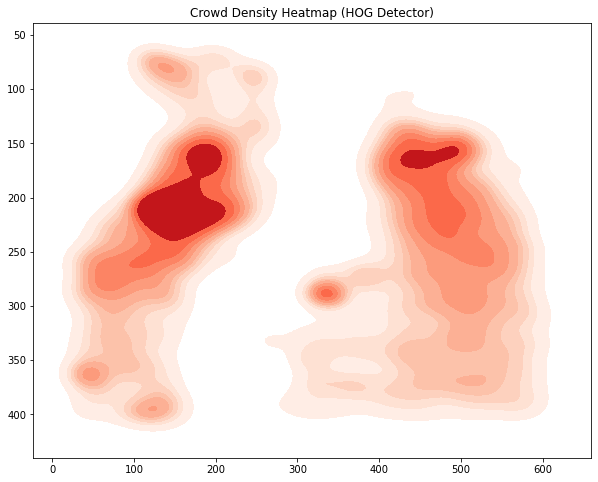

In [8]:
#  Heatmap 
if all_people_coords:
    coords_array = np.array(all_people_coords)
    plt.figure(figsize=(10, 8))
    sns.kdeplot(
        x=coords_array[:, 0],
        y=coords_array[:, 1],
        fill=True,
        cmap="Reds",
        bw_adjust=0.5,
        thresh=0.05,
    )
    plt.title('Crowd Density Heatmap (HOG Detector)')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("No people detected.")

To better visualize the dynamic changes in crowd distribution over time, we generated a separate heatmap for each frame instead of combining all frames into a single cumulative heatmap.
This approach allows us to capture and display the flow of people at each specific moment, enabling the creation of an animated visualization that shows how crowd density evolves across different time points.

In [9]:
# Setup: initialize counters and image list 
total_images_processed = 0
img_list = labels_df['filename'].tolist()

# Make sure the folder for saving heatmaps exists
os.makedirs("heatmaps", exist_ok=True)

# Go through each image one by one 
for img_file in img_list:
    total_images_processed += 1

    img_path = os.path.join(image_folder, img_file)
    img = cv2.imread(img_path)

    if img is None:
        print(f"Skipping {img_file} — file missing or unreadable.")
        continue

    # Convert image to RGB format (OpenCV loads as BGR by default)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Detect people using HOG 
    rects, weights = hog.detectMultiScale(img_rgb, winStride=(8, 8))

    # Collect center positions of all detected people
    frame_people_coords = []
    for (x, y, w, h) in rects:
        x_center = x + w / 2
        y_center = y + h / 2
        frame_people_coords.append((x_center, y_center))

    # Start plotting heatmap 
    plt.figure(figsize=(8, 6))

    draw_kde = False

    # Only draw KDE if we have at least 2 people and some spread
    if len(frame_people_coords) >= 2:
        coords_array = np.array(frame_people_coords)
        if np.var(coords_array[:, 0]) > 1e-5 or np.var(coords_array[:, 1]) > 1e-5:
            draw_kde = True

    if draw_kde:
        try:
            sns.kdeplot(
                x=coords_array[:, 0],
                y=coords_array[:, 1],
                fill=True,
                cmap="Reds",         
                bw_adjust=0.5,     
                thresh=0.05,        
            )
        except Exception as e:
            print(f"Skipped heatmap for {img_file} due to error: {e}")

    # Always draw the axes background (even if no people detected)
    plt.gca().invert_yaxis()  
    plt.axis('off')

    # Save heatmap image (same filename, different extension)
    output_path = os.path.join('heatmaps', img_file.replace('.jpg', '_heatmap.png'))
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

print(f" All done — {total_images_processed} images processed. Heatmaps saved in /heatmaps folder.")


Skipped heatmap for seq_000016.jpg due to error: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Skipped heatmap for seq_000017.jpg due to error: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Skipped heatmap for seq_000026.jpg due to error: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance 

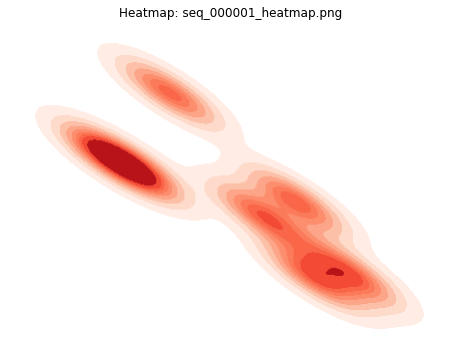

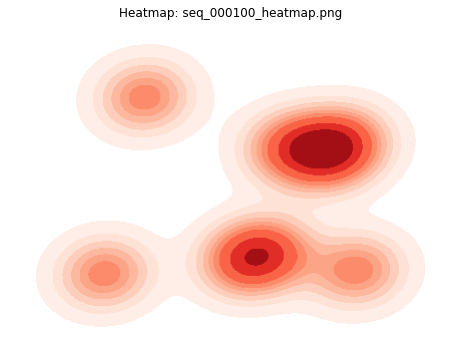

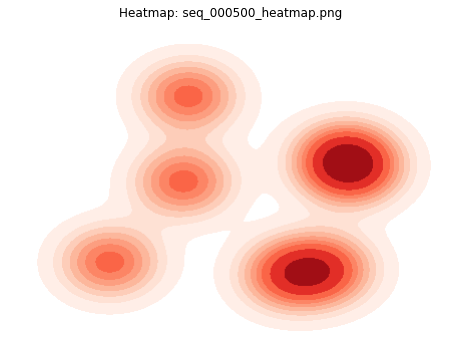

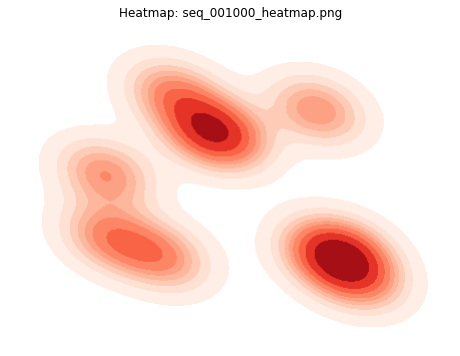

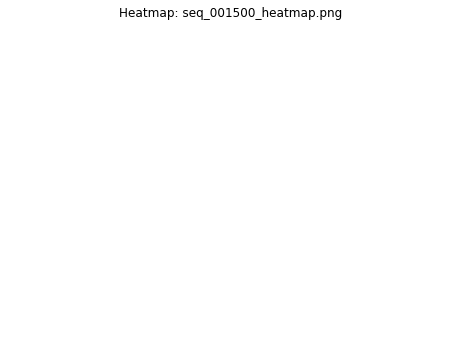

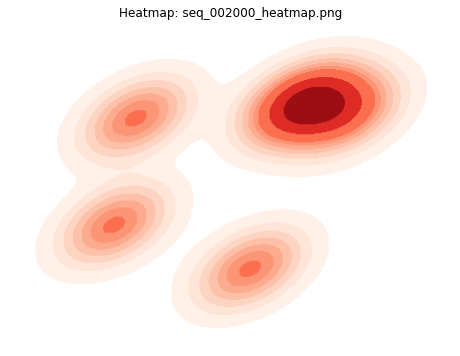

In [10]:
# Choose a few frames to visually inspect the generated heatmaps
sample_indices = [1, 100, 500, 1000, 1500, 2000]

# Folder where heatmaps were saved previously
heatmap_folder = "heatmaps"

for idx in sample_indices:
    # Format the filename (e.g., seq_000100_heatmap.png)
    file_name = f"seq_{idx:06d}_heatmap.png"
    file_path = os.path.join(heatmap_folder, file_name)

    if os.path.exists(file_path):
        img = cv2.imread(file_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(8, 6))
        plt.imshow(img_rgb)
        plt.title(f"Heatmap: {file_name}")
        plt.axis('off')
        plt.show()
    else:
        print(f"File not found: {file_name}")


In [ ]:
Evaluation

In [13]:
import numpy as np

# all_pred_counts is the number of people detected in each image
# all_true_counts is the actual number of people from labels.csv

# Ensure both lists have the same length
assert len(all_pred_counts) == len(all_true_counts)

# Calculate MAE
mae = np.mean(np.abs(np.array(all_pred_counts) - np.array(all_true_counts)))
print(f"Overall MAE: {mae:.2f} people per image")



Overall MAE: 20.00 people per image


In [14]:
# Avoid division by zero (some actual counts might be zero)
nonzero_indices = np.array(all_true_counts) != 0

mape = np.mean(
    np.abs((np.array(all_pred_counts)[nonzero_indices] - np.array(all_true_counts)[nonzero_indices]) 
    / np.array(all_true_counts)[nonzero_indices])
) * 100

print(f"Overall MAPE: {mape:.2f}%")


Overall MAPE: 76.92%


Demo Video

In [17]:
import cv2
import numpy as np
import os

# Load original video
home = os.path.expanduser('~')
video_path = os.path.join(home, 'Downloads', '111.mp4')
cap = cv2.VideoCapture(video_path)

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) or 30

# Output video path
output_path = os.path.join(home, 'Downloads', 'demo video.mp4')
out = cv2.VideoWriter(output_path,
                      cv2.VideoWriter_fourcc(*'mp4v'),
                      fps,
                      (frame_width, frame_height))

# Initialize HOG detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect people
    rects, _ = hog.detectMultiScale(frame, winStride=(8, 8))

    # Create a transparent overlay (same size as frame)
    overlay = frame.copy()

    # Define orange color (BGR) and transparency alpha
    orange = (0, 165, 255)  # OpenCV uses BGR format
    alpha = 0.4  # 0 = fully transparent, 1 = fully opaque

    # Draw semi-transparent rectangles over detected people
    for (x, y, w, h) in rects:
        cv2.rectangle(overlay, (x, y), (x + w, y + h), orange, thickness=-1)

    # Blend the overlay with the original frame
    blended = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)

    out.write(blended)

cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Done. Output saved to: {output_path}")



Done. Output saved to: C:\Users\Administrator\Downloads\demo video.mp4


Generate Heatmap as GIF (in order to observe the movement of  the crowd)

In [18]:
import imageio
import os

# Directory containing the saved heatmap images
heatmap_folder = 'heatmaps'

# Load all heatmap image filenames and sort them to preserve the correct order
image_files = sorted(
    [f for f in os.listdir(heatmap_folder) if f.endswith('_heatmap.png')]
)

# Read each image and store in a list for animation
frames = []
for filename in image_files:
    img_path = os.path.join(heatmap_folder, filename)
    frames.append(imageio.imread(img_path))

# Export the sequence of heatmaps as a GIF
gif_path = 'crowd_heatmap.gif'
imageio.mimsave(gif_path, frames, duration=0.1)  # Adjust duration as needed (0.1 sec per frame)

print(f"GIF animation complete. Saved to: {gif_path}")



GIF animation complete. Saved to: crowd_heatmap.gif
